In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [57]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [58]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


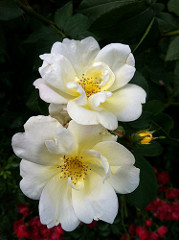

In [59]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

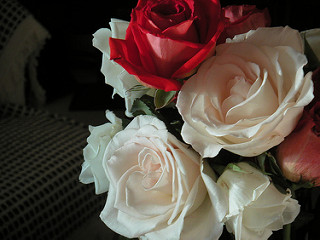

In [60]:
PIL.Image.open(str(roses[1]))

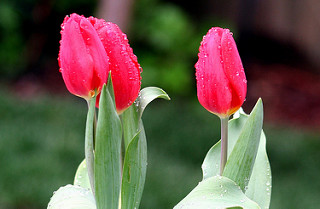

In [61]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

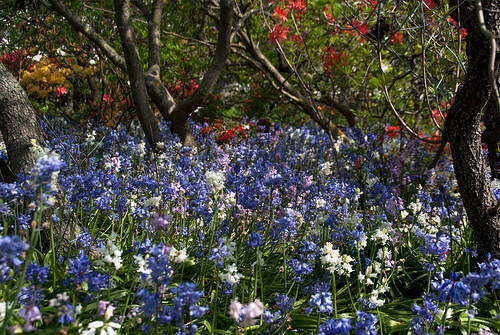

In [62]:
PIL.Image.open(str(tulips[1]))

In [63]:
batch_size = 32
img_height = 180
img_width = 180

In [64]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [65]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [66]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


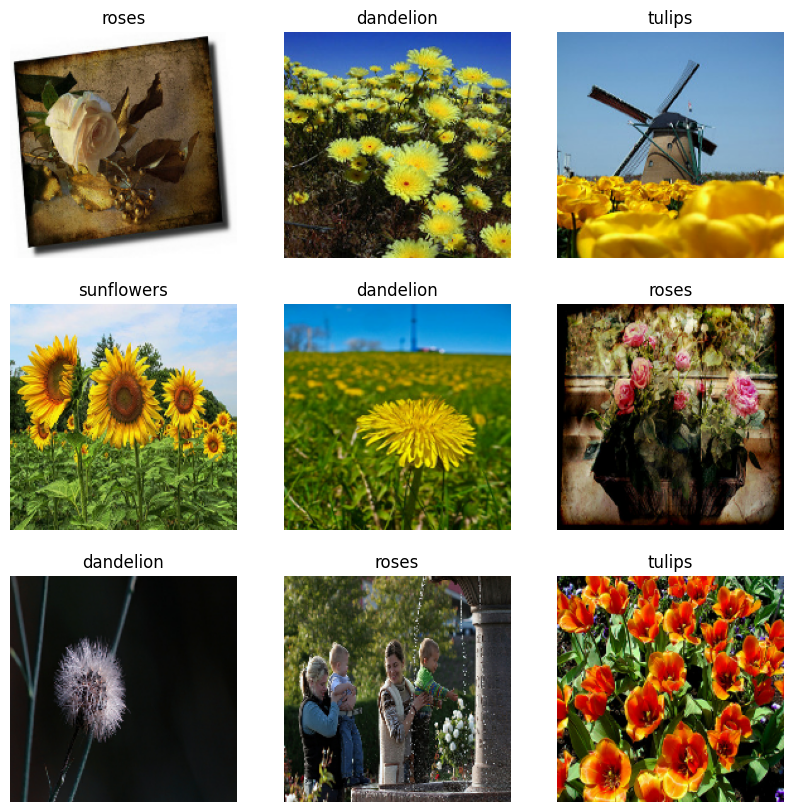

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [69]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [70]:
normalization_layer = layers.Rescaling(1./255)

Créer le modèle


In [71]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [74]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 20s 193ms/step - loss: 1.3884 - accuracy: 0.3750 - val_loss: 1.1431 - val_accuracy: 0.5300
Epoch 2/10
92/92 [==============================] - 37s 400ms/step - loss: 1.0751 - accuracy: 0.5623 - val_loss: 1.0347 - val_accuracy: 0.5749
Epoch 3/10
92/92 [==============================] - 51s 550ms/step - loss: 0.9175 - accuracy: 0.6417 - val_loss: 0.9364 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 50s 539ms/step - loss: 0.7115 - accuracy: 0.7268 - val_loss: 0.9796 - val_accuracy: 0.6390
Epoch 5/10
92/92 [==============================] - 52s 570ms/step - loss: 0.5393 - accuracy: 0.8014 - val_loss: 0.9816 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 50s 546ms/step - loss: 0.3511 - accuracy: 0.8811 - val_loss: 1.1154 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 48s 521ms/step - loss: 0.2502 - accuracy: 0.9230 - val_loss: 1.1103 - val_accuracy: 0.6649

In [75]:
import pynvml

# Initialize NVML
pynvml.nvmlInit()

# Get the number of available GPUs
device_count = pynvml.nvmlDeviceGetCount()

# Iterate through each GPU
for i in range(device_count):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    
    # Get GPU name
    name = pynvml.nvmlDeviceGetName(handle)
    print(f"GPU {i}: {name}")

    # Get GPU utilization
    utilization = pynvml.nvmlDeviceGetUtilizationRates(handle)
    print(f"  Utilization: {utilization.gpu}%")

# Shutdown NVML
pynvml.nvmlShutdown()


GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
  Utilization: 34%


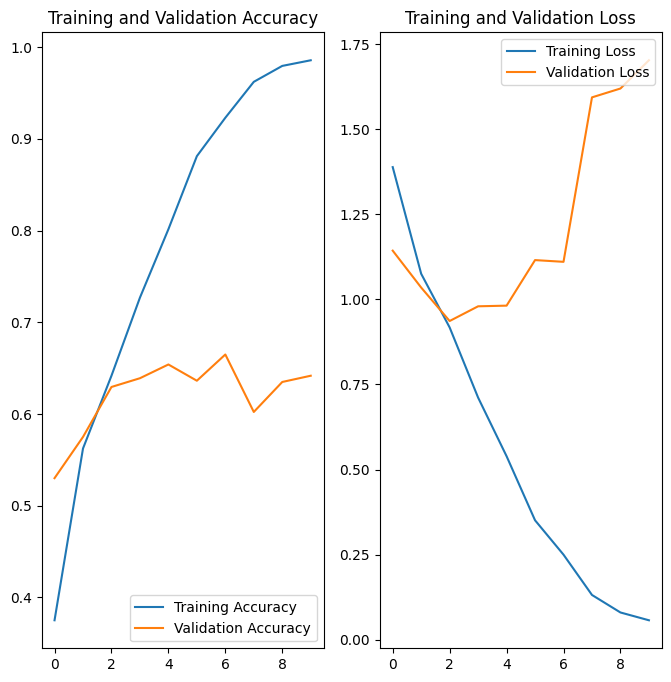

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

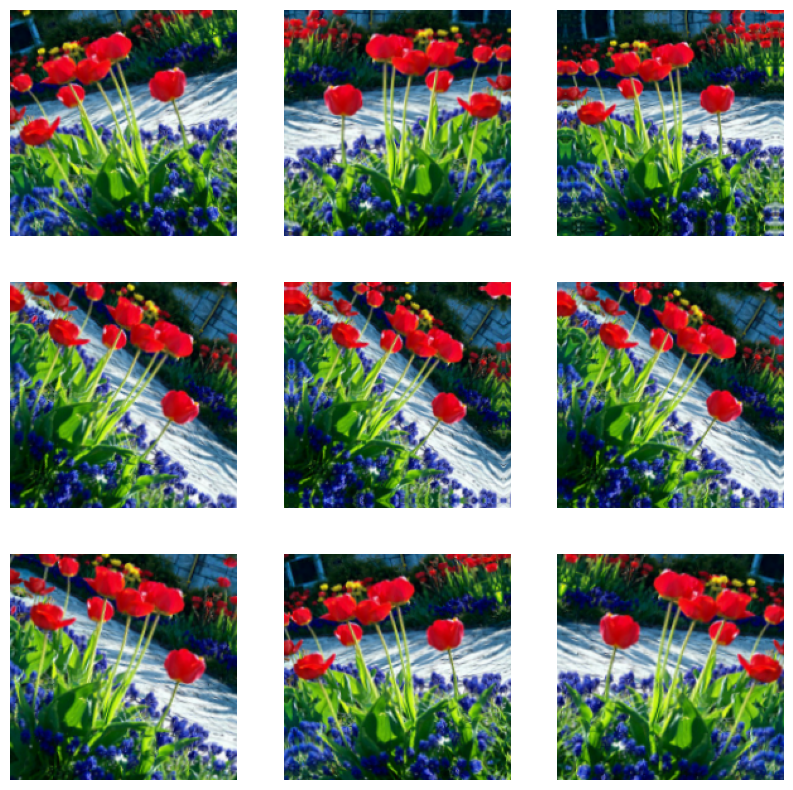

In [78]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [79]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [80]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [82]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 57s 606ms/step - loss: 1.3627 - accuracy: 0.4101 - val_loss: 1.1649 - val_accuracy: 0.5163
Epoch 2/15
92/92 [==============================] - 46s 502ms/step - loss: 1.1115 - accuracy: 0.5409 - val_loss: 1.1136 - val_accuracy: 0.5422
Epoch 3/15
92/92 [==============================] - 24s 267ms/step - loss: 1.0030 - accuracy: 0.6066 - val_loss: 0.9399 - val_accuracy: 0.6253
Epoch 4/15
92/92 [==============================] - 57s 616ms/step - loss: 0.9384 - accuracy: 0.6417 - val_loss: 0.9019 - val_accuracy: 0.6553
Epoch 5/15
92/92 [==============================] - 57s 618ms/step - loss: 0.8437 - accuracy: 0.6775 - val_loss: 0.9788 - val_accuracy: 0.6403
Epoch 6/15
92/92 [==============================] - 57s 616ms/step - loss: 0.8168 - accuracy: 0.6846 - val_loss: 0.8362 - val_accuracy: 0.6948
Epoch 7/15
92/92 [==============================] - 57s 622ms/step - loss: 0.7361 - accuracy: 0.7255 - val_loss: 0.7625 - val_accuracy: 0.7057

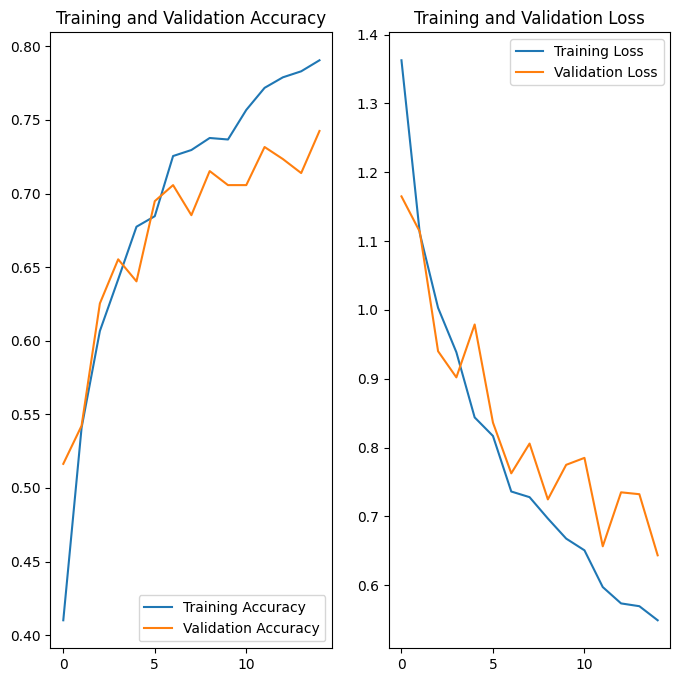

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [84]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 128ms/step
This image most likely belongs to sunflowers with a 99.41 percent confidence.
